In [1]:
import json
import io

import seaborn as sns
import numpy as np
import pandas as pd

from scipy import stats

from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Obtenção de Dados #

Devido ao fato de haverem poucos dados (325 registros) disponíveis na Punk API, fez-se necessário obter uma base de dados maior através da internet, a base foi obtida em: https://www.kaggle.com/angeredsquid/brewers-friend-beer-recipes. Essa base de dados contém todas as receitas de cerveja cadastradas em https://www.brewersfriend.com/search/ até julho de 2020 totalizando 179455 registros.


In [2]:
# Must descompact brewing_friends.zip
# Convert data from json to csv (brewing_friends.json to brewing_friends.csv)

origin = "brewing_friends.json"
destination = "brewing_friends.csv"

f = io.open(origin, "r")

file_data = f.read()

f.close()

f = io.open(destination, "w", encoding = "utf-8")

data = json.loads(file_data)

csv_header = "\"abv\",\"target_fg\",\"target_og\",\"srm\",\"ph\",\"ibu\"\n"
f.write(csv_header)

for key in data.keys():
    
    record = data[key]
    
    csv_record = "\"{abv}\",\"{target_fg}\",\"{target_og}\",\"{srm}\",\"{ph}\",\"{ibu}\"\n".format(
        abv = record["abv"],
        target_fg = record["fg"],
        target_og = record["og"],
        srm = record["color"],
        ph = record["ph mash"] if record["ph mash"] != -1 else "",
        ibu = record["ibu"]
    )
    
    f.write(csv_record)

f.close()

Carregamento dos dados em um DataFrame para posterior processamento

In [3]:
df = pd.read_csv("brewing_friends.csv", sep = ",")
df.head()

,abv,target_fg,target_og,srm,ph,ibu
0,5.48,1.013,1.055,4.83,NaN,19.44
1,6.50,1.013,1.062,5.20,5.49,59.26
2,5.58,1.013,1.055,8.00,5.67,39.79
3,5.94,1.016,1.061,8.50,5.81,62.42
4,7.09,1.018,1.072,6.33,NaN,232.89


# Estatística Descritiva #

Nessa parte é analisada a estatística descritiva de cada uma das variáveis do dataset, observou-se que a variável PH possui um grande número de informações faltantes.

In [4]:
df.describe()

,abv,target_fg,target_og,srm,ph,ibu
count,179455.000000,179455.000000,179455.000000,179455.000000,40245.000000,179455.000000
mean,6.026853,1.012500,1.058432,12.811946,5.492687,38.899209
std,1.837750,0.032155,0.050765,12.607527,0.554685,43.198490
min,0.000000,0.000000,0.000000,0.000000,0.290000,0.000000
25%,5.000000,1.010000,1.049000,4.760000,5.400000,19.970000
50%,5.710000,1.013000,1.056000,7.650000,5.560000,32.150000
75%,6.740000,1.016000,1.066000,15.310000,5.700000,50.550000
max,24.980000,3.974000,15.897000,305.000000,79.000000,4767.930000


Com o propósito de analisar a relação entre as variáveis, descartou-se todas os registros que possuíssem pelo menos 1 coluna com valor nulo.

In [5]:
df_test = df.dropna(how = "any", inplace = False)
df_test.describe()

,abv,target_fg,target_og,srm,ph,ibu
count,40245.000000,40245.000000,40245.000000,40245.000000,40245.000000,40245.000000
mean,6.063424,1.013289,1.059370,13.155108,5.492687,39.384188
std,1.739164,0.005375,0.016557,13.631642,0.554685,36.967597
min,0.000000,0.995000,1.000000,0.000000,0.290000,0.000000
25%,5.020000,1.010000,1.049000,4.730000,5.400000,21.740000
50%,5.720000,1.013000,1.056000,7.440000,5.560000,32.770000
75%,6.740000,1.016000,1.066000,15.670000,5.700000,50.000000
max,24.340000,1.125000,1.247000,305.000000,79.000000,2704.290000


Para reduzir o ruído dos dados (remover outliers), calculou-se o z-score (distância em desvio padrão) para cada valor referente a sua variável (abv, fg, og, srm, ph e ibu), e removeram-se os valores que estavam acima de 3 desvios padrões de distância em relação a média da variável.

In [6]:
z = np.abs(stats.zscore(df_test))
threshould = 3 # 3 distância em desvio padrão
df_test = df_test[(z < threshould).all(axis = 1)]
df_test.describe()

,abv,target_fg,target_og,srm,ph,ibu
count,38284.000000,38284.000000,38284.000000,38284.000000,38284.000000,38284.000000
mean,5.919433,1.012896,1.057948,12.226623,5.521141,37.226230
std,1.428327,0.004425,0.013587,11.463988,0.280748,24.296069
min,0.950000,0.998000,1.010000,0.000000,3.830000,0.000000
25%,5.000000,1.010000,1.049000,4.670000,5.400000,21.627500
50%,5.680000,1.012000,1.056000,7.240000,5.570000,32.350000
75%,6.630000,1.015000,1.065000,14.770000,5.700000,48.650000
max,11.280000,1.029000,1.109000,53.860000,7.130000,150.100000


Calculou-se então, a Correlação de Pearson para verificar se existe alguma variável altamente correlacionada que pudesse ser útil para realizar a predição dos valores dos IBUs

In [7]:
df_test.corr(method = "pearson")

,abv,target_fg,target_og,srm,ph,ibu
abv,1.000000,0.497258,0.958767,0.256880,-0.026304,0.323234
target_fg,0.497258,1.000000,0.720370,0.361695,-0.051456,0.189657
target_og,0.958767,0.720370,1.000000,0.322261,-0.036879,0.319128
srm,0.256880,0.361695,0.322261,1.000000,-0.257852,0.063452
ph,-0.026304,-0.051456,-0.036879,-0.257852,1.000000,-0.008392
ibu,0.323234,0.189657,0.319128,0.063452,-0.008392,1.000000


Plotou-se o gráfico de dispersão das variáveis para verificar a relação entre as variáveis (ABV, FG, OG, SRM e PH) e o IBU, e constatou-se que não existe uma linearidade entre elas.

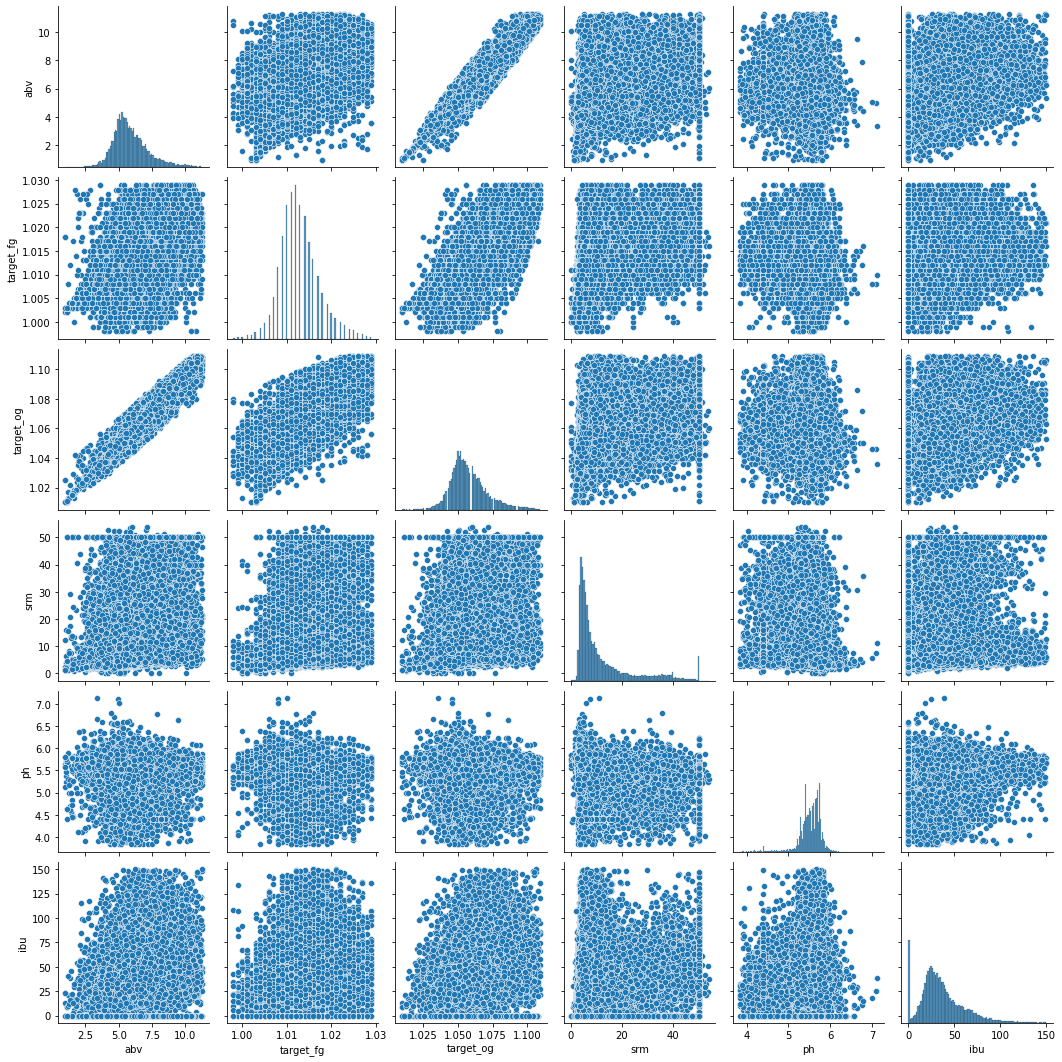

In [8]:
sns.pairplot(df_test)

Voltando ao dataset original, calculou-se o número de valores nulo para cada variável, e constatou-se que a única variável contendo valroes nulos era o ph, contendo 139210 valores nulos, o que corresponde a 77,6% dos registros existentes na base de dados.

In [9]:
abv = df["abv"].isnull().sum()
target_fg = df["target_fg"].isnull().sum()
target_og = df["target_og"].isnull().sum()
srm = df["srm"].isnull().sum()
ph = df["ph"].isnull().sum()
ibu = df["ibu"].isnull().sum()

print("abv: " + str(abv))
print("target_fg: " + str(target_fg))
print("target_og: " + str(target_og))
print("srm: " + str(srm))
print("ph: " + str(ph))
print("ibu: " + str(ibu))

abv: 0
target_fg: 0
target_og: 0
srm: 0
ph: 139210
ibu: 0


Para não descartar 77,6% dos registros, optou-se por remover a variável ph.

In [10]:
drop = ['ph']
df.drop(drop, axis = 1, inplace = True)
df.head()

,abv,target_fg,target_og,srm,ibu
0,5.48,1.013,1.055,4.83,19.44
1,6.50,1.013,1.062,5.20,59.26
2,5.58,1.013,1.055,8.00,39.79
3,5.94,1.016,1.061,8.50,62.42
4,7.09,1.018,1.072,6.33,232.89


Novamente, aplica-se a técnica de remoção de ruído usando o z-score.

In [11]:
z = np.abs(stats.zscore(df))
threshould = 3 # 3 distância em desvio padrão
view = np.where(z > threshould)
df = df[(z < threshould).all(axis = 1)]
df.describe()

,abv,target_fg,target_og,srm,ibu
count,174069.000000,174069.000000,174069.000000,174069.000000,174069.000000
mean,5.922171,1.013274,1.058352,12.371319,37.013417
std,1.511941,0.004840,0.014703,11.493347,26.874751
min,0.520000,0.987000,1.000000,0.000000,0.000000
25%,4.990000,1.010000,1.049000,4.740000,20.080000
50%,5.690000,1.013000,1.056000,7.580000,31.990000
75%,6.660000,1.016000,1.065000,14.920000,49.740000
max,11.540000,1.096000,1.165000,50.600000,168.420000


Plota-se novamente o gráfico de dispersão para verificar se não houveram alterações com um maior número de dados.

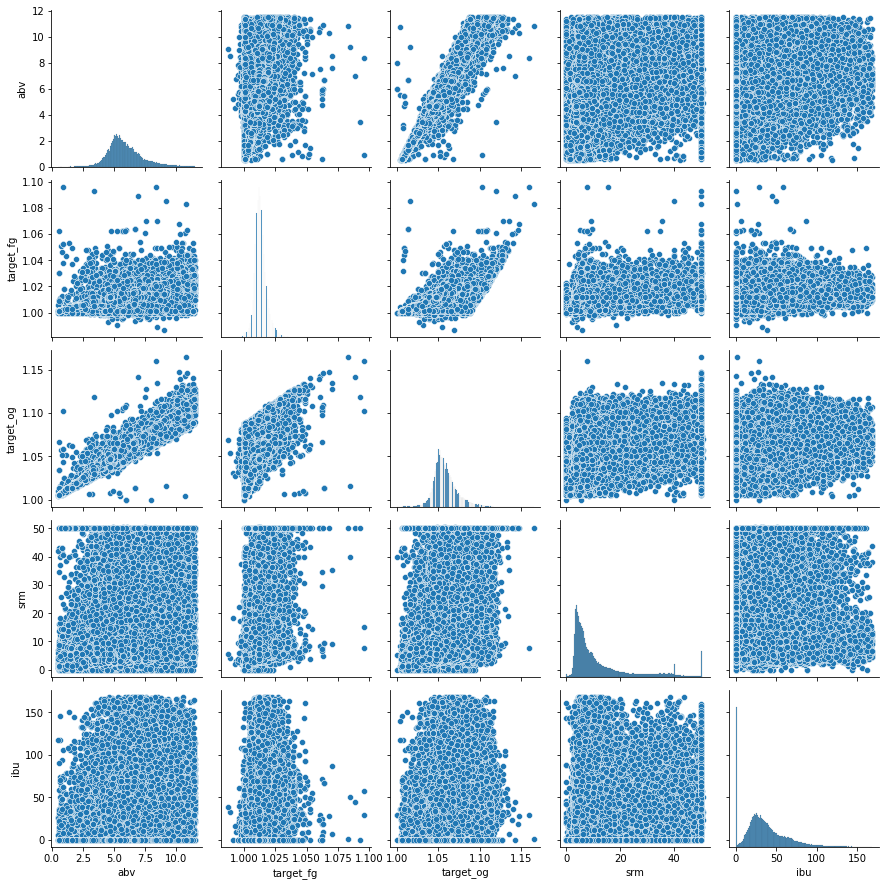

In [13]:
sns.pairplot(df)

Separa-se as variáveis (abv, fg, og e srm) como features e a variável (ibu) como target para serem utilizadas durante o processo de treinamento.

In [14]:
# Features
X = df.iloc[:, 0:4].to_numpy()
# Targets (IBUs)
y = df.iloc[:, 4:].to_numpy().flatten()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle = False)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(156662, 4)
(17407, 4)
(156662,)
(17407,)


Treina-se o baseline model e observa-se que o mesmo está sofrendo de um overfitting nos dados, pois obteve o erro médio absoluto de 6 para os dados de treinamento e 19 para dados de teste. O erro médio absoluto o quanto uma previsão está errada para cima ou para baixo, em média.

In [ ]:
rf_regressor = RandomForestRegressor(n_estimators = 100, random_state = 42)

rf_regressor.fit(X_train, y_train)

y_train_predicted = rf_regressor.predict(X_train)
y_test_predicted = rf_regressor.predict(X_test)

print("TRAIN MAE: " + str(mean_absolute_error(y_train, y_train_predicted)))
print("TRAIN MSE: " + str(mean_squared_error(y_train, y_train_predicted)))

print("TEST MAE: " + str(mean_absolute_error(y_test, y_test_predicted)))
print("TEST MSE: " + str(mean_squared_error(y_test, y_test_predicted)))

print("=====TRAINING PREDICTION=====")

for i in range(0, 20, 1):
    
    X = X_train[i]
    y_expected = y_train[i]
    
    y_predicted = rf_regressor.predict([X])[0]
    
    print("y_espected: " + str(y_expected) + " y_predicted: " + str(y_predicted) + " absolute difference: " + str(np.abs(y_expected - y_predicted)))

print("=====TEST PREDICTION=====")
    
for i in range(0, 20, 1):
    
    X = X_test[i]
    y_expected = y_test[i]
    
    y_predicted = rf_regressor.predict([X])[0]
    
    print("y_espected: " + str(y_expected) + " y_predicted: " + str(y_predicted) + " absolute difference: " + str(np.abs(y_expected - y_predicted)))

Para combater o overfitting optou-se por fazer uma busca em grid de parâmetros para tentar reduzir o erro médio absoluto em teste

In [ ]:
model = RandomForestRegressor()

parameters = {
    'max_depth': [5, 10, 20, 30],
    #"min_samples_split": [10, 25, 50, 75, 100],
    #'max_leaf_nodes': [10, 25, 50, 75, 100],
    "min_samples_leaf": [10, 25, 50, 75, 100],
    'n_estimators': [50, 100, 150, 200, 250],
    'max_samples': [0.6, 0.7, 0.8, 0.9, 1],
    'max_features': [ "log2" ]
}

selector = GridSearchCV(
    model, 
    param_grid = parameters,
    scoring = 'neg_mean_absolute_error',
    #n_iter = 3600,
    n_jobs = -1,
    cv = 5,
    refit = True,
    #random_state = 42,
    verbose = 2
)

selector.fit(X_train, y_train)

print("Best Score: " + str(selector.best_score_))
print("Best Params: " + str(selector.best_params_))

In [ ]:
y_train_predicted = selector.best_estimator_.predict(X_train)
y_test_predicted = selector.best_estimator_.predict(X_test)

print("TRAIN MAE: " + str(mean_absolute_error(y_train, y_train_predicted)))
print("TRAIN MSE: " + str(mean_squared_error(y_train, y_train_predicted)))

print("TEST MAE: " + str(mean_absolute_error(y_test, y_test_predicted)))
print("TEST MSE: " + str(mean_squared_error(y_test, y_test_predicted)))

print("=====TRAINING PREDICTION=====")

for i in range(0, 20, 1):
    
    X = X_train[i]
    y_expected = y_train[i]
    
    y_predicted = rf_regressor.predict([X])[0]
    
    print("y_espected: " + str(y_expected) + " y_predicted: " + str(y_predicted) + " absolute difference: " + str(np.abs(y_expected - y_predicted)))

print("=====TEST PREDICTION=====")
    
for i in range(0, 20, 1):
    
    X = X_test[i]
    y_expected = y_test[i]
    
    y_predicted = rf_regressor.predict([X])[0]
    
    print("y_espected: " + str(y_expected) + " y_predicted: " + str(y_predicted) + " absolute difference: " + str(np.abs(y_expected - y_predicted)))

# Conclusões #

Analisando as 20 primeiras predições tanto no baseline model quanto no modelo obtido através de cross validation observou-se que a maioria dos erros ocorre quando o valor esperado para o IBU é 0 ou acima de 50, um fato que faz sentido se observarmos que existe um grande número de cervejas com IBU 0 na base de dados, e que existem poucas cervejas com IBU acima de 50, como pode ser observado no histograma a baixo.

In [ ]:
sns.displot(df, x = "ibu")

O modelo atual possui um erro médio absoluto de 18, errando em média 18 pontos para cima ou para baixo nos valores preditos. Algumas possíveis ações que poderia se tomar para melhorar o desempenho é investigar a ocorrência em demasia de valores 0 para o IBU, realizar novas buscas de hyperparâmetros ou testar outras abordagens de regressão como XGBoost ou SVMs.